In [1]:
import csv
import math
import json
import os
import cv2

from PIL import Image, ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, Flatten, Dropout, Dense, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import Adam

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/home/acer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Preprocessing ###
Building up our training set, validation set and images from Pascal 2007 dataset.

In [2]:
path = os.getcwd()
dataset_path = os.path.join(os.getcwd(), "dataset/Annotations")
image_path = os.path.join(os.getcwd(), "dataset/JPEGImages")

train_path = os.path.join(dataset_path, "pascal_train2007.json")
val_path = os.path.join(dataset_path, "pascal_val2007.json")

# building up training dataset
with open(train_path) as f:
    train_data = json.load(f)

train_dataset = []
for image in train_data["images"]:
    image_set = {}
    image_set["image"] = image
    
    anno_list = []
    for anno in train_data["annotations"]:
        if anno["image_id"] == image['id']:
            anno_list.append(anno)
    image_set["annotation"] = sorted(anno_list, key=lambda x:x["area"], reverse=True)[0]
    train_dataset.append(image_set)


# building up validation dataset    
with open(val_path) as f:
    val_data = json.load(f)
    
val_dataset = []
for image in val_data["images"]:
    image_set = {}
    image_set["image"] = image
    
    anno_list = []
    for anno in val_data["annotations"]:
        if anno["image_id"] == image["id"]:
            anno_list.append(anno)
    image_set["annotation"] = sorted(anno_list, key=lambda x:x["area"], reverse=True)[0]
    val_dataset.append(image_set)

# redistribute list
combine_list = train_dataset + val_dataset
train_dataset = combine_list[:int(len(combine_list) * 0.8)]
val_dataset = combine_list[int(len(combine_list) * 0.8):]
    
# converter to convert id to label name
id_to_name = {c['id']:c['name'] for c in train_data['categories']}

print(train_data.keys())
print()
print("images: {}\n".format(train_data['images'][0]))
print("annotations: {}\n".format(train_data['annotations'][0]))
print("categories: {}\n".format(train_data['categories'][0]))

dict_keys(['images', 'type', 'annotations', 'categories'])

images: {'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}

annotations: {'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}

categories: {'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}



In [3]:
print("Combine dataset: {}".format(len(combine_list)))
print("Train dataset: {}".format(len(train_dataset)))
print("Validate dataset: {}".format(len(val_dataset)))

Combine dataset: 5011
Train dataset: 4008
Validate dataset: 1003


### Data exploration ###
Exploring and resizing our images to see how they looks like

In [4]:
def bb_hw(a): 
    x0 = bbox[0]
    y0 = height - bbox[1] - bbox[3]
    x1 = bbox[2]
    y1 = bbox[3]
    return  [x0, y0, x1, y1]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def show_img(im, figsize=(5, 5), dpi=100, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    return ax

def load_image(path):
    img = cv2.imread(path, 1) 
    return img[..., ::-1]

To visualise how much augmentation should be apply to our image we must also look at what we have in our dataset.<br>
Change the number in *data = train_dataset[19]* to view different images.

{'image': {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}, 'annotation': {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]], 'area': 81326, 'iscrowd': 0, 'image_id': 17, 'bbox': [89, 77, 314, 259], 'category_id': 13, 'id': 3, 'ignore': 0}}
[41, 47, 146, 159]
(224, 224, 3)


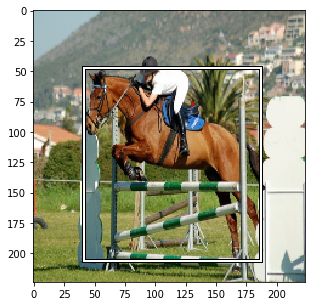

In [5]:
IMAGE_SIZE = 224
data = train_dataset[1]
print(data)
img_path = os.path.join(image_path, data["image"]['file_name'])

ori_img = Image.open(img_path)
img = np.array(ori_img)
height = data["image"]["height"]
width = data["image"]["width"]

x0, y0, x1, y1 = data['annotation']["bbox"]

x_scale = IMAGE_SIZE / width
y_scale = IMAGE_SIZE / height

x0 = int(x0 * x_scale)
y0 = int(y0 * y_scale)
x1 = int(x1 * x_scale)
y1 = int(y1 * y_scale)
bbox = [x0, y0, x1, y1]
print(bbox)

img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = img.astype("float") / 255.0
print(img.shape)
# print(img)

ax = show_img(img)
draw_rect(ax, bbox)

ori_img.close()

### Image Augmentation ###
As we know image augmentation is usually apply to improve model robustness and help to generalise better. This is also a good way to increase our dataset size if our dataset is relatively small. But do take note that augment image too agressive will cost model not able to learn. We should always augment image in ways that could happen in real production usage. Eg. Lightings (bright or dark), orientation (horizontal or vertial flip), colors (Orange or blue light filters), etc. Take it as these augmentation is to prepare our model to work on foreseeable problems.<br><br>
**NOTE:** <br>
Since we are building a model detect single object with bounding box, augmentation techniques like rotation or scaling will affect bounding box position. We need to apply the same augmentation to the bounding box too. It is not discuss here refer to augmentation notebook for further details.

In [6]:
import imgaug as ia
from imgaug import augmenters as iaa
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def aug_image(img, bbox):
    # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
    # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images                    
            
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 3),
                [
                    sometimes(iaa.Affine(rotate=(-45, 45))),
                    # sometimes(iaa.Superpixels(p_replace=(0, 0.3), n_segments=(0, 100))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                    # iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                    ]),
                    iaa.Invert(0.05, per_channel=True), # invert color channels
                    iaa.Add((0, 20), per_channel=0.5), # change brightness of images (by 0 to 20 of original value)
                    iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.5, 1.5), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-4, 0),
                            first=iaa.Multiply((0.5, 1.5), per_channel=True),
                            second=iaa.ContrastNormalization((0.5, 2.0))
                        )
                    ]),
                    iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                    iaa.Grayscale(alpha=(0.0, 1.0)),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.04))), # sometimes move parts of the image around
                    # sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.05)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    
    # take note that pascal bbox is in x1, y1, width ,height
    # bbox should hold x1, y1, x2, y2
    bbs = ia.BoundingBoxesOnImage([
        ia.BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[0]+bbox[2], y2=bbox[1]+bbox[3]),    
    ], shape=img.shape)
    
    # create fix augment sequence
    seq_det = seq.to_deterministic()

    image_aug = np.array(seq_det.augment_images([img])[0])
    bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]
    
    bbox_list = []
    for i in range(len(bbs.bounding_boxes)):
        bbox_after = bbs_aug.bounding_boxes[i]
        bbox_after = [bbox_after.x1, bbox_after.y1, bbox_after.x2, bbox_after.y2]
        bbox_list.append(bbox_after)
    # take note that return augmented bbox result is in x1, y1, x2, y2
    return image_aug, bbox_list

Every run the augmented image will be different this extends variety for our model to learn. <br>
*Enter any key to iterate through the images and 'q' key to exit*

In [17]:
for idx, data in enumerate(train_dataset):
    img_path = os.path.join(image_path, data["image"]['file_name'])    
    x_scale = IMAGE_SIZE / data["image"]["width"]
    y_scale = IMAGE_SIZE / data["image"]["height"]
    x0, y0, width, height = data['annotation']["bbox"]
    # scale the bbox
    x0, y0, width, height = x0 * x_scale, y0 * y_scale, width * x_scale, height * y_scale    
    
    # scale the image
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))        
    
    # augment the image and bbox
    img, bbox_list = aug_image(img, np.array([x0, y0, width, height], dtype=np.int32))        
    
    bbox = np.array(bbox_list[0], dtype=np.int32)            
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 2)
    cv2.imshow("image", img)                
        
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
        
    cv2.destroyAllWindows()

[ 69  64 156 181]
[ 36  47 182 206]
[ 61   0 222 206]
[ 73  83 184 142]
[ 56  61 177 145]
[  1  64 220 160]


### Building custom model ###
We will be building a custom model to draw bounding box around the largest classified item in our image. We will create a custom validation which calculate the IoU between the actual and prediction bounding box. Our model is a simple model using layers of dense and dropout. We also use GlobalAveragePooling2D instead of flatten layer because the primal provides better extraction of features than flatten on images. <br>
**Result:**<br>
Model produce the result of 0.52 AP not the best but in research papers this is usually the baseline.

In [20]:
# determin percentage of MobileNetV2 will be used **Check later
ALPHA = 1.3

# training parameters
BATCH_SIZE = 64
# 96, 128, 160, 192, 224
IMAGE_SIZE = 224
EPOCHS = 200
PATIENCE = 50
MULTI_PROCESSING = True
THREADS = 4

class DataGenerator(Sequence):

    def __init__(self, dataset, is_augmentated=False):
        self.is_augmentated = is_augmentated
        self.paths = []
        self.coords = np.zeros((len(dataset), 4))
        
        for idx, data in enumerate(dataset):
            img_path = os.path.join(image_path, data["image"]['file_name'])
            self.paths.append(img_path)
            
            x_scale = IMAGE_SIZE / data["image"]["width"]
            y_scale = IMAGE_SIZE / data["image"]["height"]
            x0, y0, width, height = data['annotation']["bbox"]
            # scale the bbox
            x0, y0, width, height = x0 * x_scale, y0 * y_scale, width * x_scale, height * y_scale
                        
            self.coords[idx, 0] = int(x0)
            self.coords[idx, 1] = int(y0)
            self.coords[idx, 2] = int(width)
            self.coords[idx, 3] = int(height)
            
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    def __getitem__(self, idx):
        # print("Range: {} {} ".format(idx * BATCH_SIZE, (idx + 1) * BATCH_SIZE))
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        
        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):                        
            img = cv2.imread(f, 1)
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))            
                        
            x1, y1, width, height = batch_coords[i][0], batch_coords[i][1], batch_coords[i][2], batch_coords[i][3]      
            if(self.is_augmentated):
                # NOTE: augmented bbox is different from orignal bbox
                # pascal: x1, y1, width ,height
                # augmented: x1, y1, x2, y2                                                  
                img, bbox_list = aug_image(img, np.array([x1, y1, width, height], dtype=np.int32))                
                batch_coords[i] = bbox_list[0]
            else:                
                batch_coords[i] = [x1, y1, x1 + width, y1 + height]
      
            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))            
        return batch_images, batch_coords

    
class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator
    
    def on_epoch_end(self, epoch, logs):
        mse = 0
        intersections = 0
        unions = 0
        
        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i]
            pred = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]
            
            pred = np.maximum(pred, 0)
            
            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)
            
            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = np.maximum(area_gt + area_pred - intersection, 0)

            intersections += np.sum(intersection * (union > 0))
            unions += np.sum(union)
            
        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        mse = np.round(mse, 4)
        logs["val_mse"] = mse 
        print(" - val_iou: {} - val_mse: {}".format(iou, mse))

        
def create_model(trainable=False):
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)
    
    # freeze layers
    for layer in model.layers:
        layer.trainable = trainable
    
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4)(x)    
    
    return Model(inputs=model.input, outputs=x)

### Visualise image generated by DataGenerator ###

The image looks darker because we apply preprocess_input from MobileNetV2. This allow our image to be accepted by the model as input.

In [23]:
datagen = DataGenerator(train_dataset, is_augmentated=True)
batch_images, batch_coords = datagen.__getitem__(0)

for idx, img in enumerate(batch_images):
    img = batch_images[idx]
    bbox = batch_coords[idx] 
    bbox = np.array(bbox, dtype=np.int32)    
    
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 2)
    cv2.imshow("image", img)

    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
        
cv2.destroyAllWindows()

In [7]:
model = create_model()

# WEIGHTS_FILE = "model-0.52.h5"
# model.load_weights(WEIGHTS_FILE)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 40) 1080        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 40) 160         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [8]:
train_datagen = DataGenerator(train_dataset, is_augmentated=True)
val_datagen = Validation(generator=DataGenerator(val_dataset, is_augmentated=True))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[])

checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True, 
                             save_weights_only=True, mode="max", period=1)
earlystop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

history = model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_datagen, checkpoint, reduce_lr, earlystop],
                    workers=THREADS,
                    use_multiprocessing=False,
                    shuffle=True,
                    verbose=1)

Epoch 1/200
62/63 [============================>.] - ETA: 0s - loss: 1040.1214 - val_iou: 0.5201 - val_mse: 154.6972

Epoch 00001: val_iou improved from -inf to 0.52010, saving model to model-0.52.h5
63/63 [==============================] - 24s 387ms/step - loss: 1039.1192
Epoch 2/200
62/63 [============================>.] - ETA: 0s - loss: 1014.8338 - val_iou: 0.5168 - val_mse: 158.789

Epoch 00002: val_iou did not improve from 0.52010
63/63 [==============================] - 12s 195ms/step - loss: 1016.6801
Epoch 3/200
62/63 [============================>.] - ETA: 0s - loss: 1031.9816 - val_iou: 0.5171 - val_mse: 156.4172

Epoch 00003: val_iou did not improve from 0.52010
63/63 [==============================] - 12s 193ms/step - loss: 1030.7350
Epoch 4/200
62/63 [============================>.] - ETA: 0s - loss: 1023.2794 - val_iou: 0.5125 - val_mse: 160.7588

Epoch 00004: val_iou did not improve from 0.52010
63/63 [==============================] - 12s 193ms/step - loss: 1023.3390
E

Epoch 34/200
62/63 [============================>.] - ETA: 0s - loss: 952.5380 - val_iou: 0.5234 - val_mse: 153.9975

Epoch 00034: val_iou did not improve from 0.52380
63/63 [==============================] - 12s 195ms/step - loss: 952.5392
Epoch 35/200
62/63 [============================>.] - ETA: 0s - loss: 939.5889 - val_iou: 0.5231 - val_mse: 154.1501

Epoch 00035: val_iou did not improve from 0.52380
63/63 [==============================] - 12s 193ms/step - loss: 939.2183
Epoch 36/200
62/63 [============================>.] - ETA: 0s - loss: 967.6371 - val_iou: 0.5234 - val_mse: 154.299

Epoch 00036: val_iou did not improve from 0.52380

Epoch 00036: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
63/63 [==============================] - 12s 193ms/step - loss: 967.3239
Epoch 37/200
62/63 [============================>.] - ETA: 0s - loss: 943.7886 - val_iou: 0.5229 - val_mse: 154.0948

Epoch 00037: val_iou did not improve from 0.52380
63/63 [======================

### Testing our model ##
We test our model by loading our trained weights. It does fairly, I expected more but its only at baseline. Hopefully we could improve this. <br><br>
Darn no improvement at all, complex model don't always perform better. We need a way to see what the model have learn. Then probably we could find a way to improve its performance. <br>
Still stuck at 0.52 AP

In [ ]:
import glob
import cv2

WEIGHTS_FILE = "model-0.52.h5"

model = create_model()
model.load_weights(WEIGHTS_FILE)

In [ ]:
for filename in glob.glob("dataset/JPEGImages/*jpg"):
    unscaled = cv2.imread(filename)
    image_height, image_width, _ = unscaled.shape
    print(unscaled.shape)
    
    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
    
    region = model.predict(x=np.array([feat_scaled]))[0]
    
    x0 = int(region[0] * image_width / IMAGE_SIZE)
    y0 = int(region[1] * image_height / IMAGE_SIZE)
    
    x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
    y1= int((region[1] + region[3]) * image_height / IMAGE_SIZE)
    print((x0, y0), (x1, y1))
    
    cv2.rectangle(unscaled, (x0, y0), (x1, y1), (0, 0, 255), 1)
    cv2.imshow("image", unscaled)
    
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break    
    cv2.destroyAllWindows()

### Use a skip-net architecture similar to U-Net ###
** Can we improve this?** <br>
What if we provide a more complex model will it able to learn better than the previous one. I came across this network architecture call U-Net which is commonly use in medical imagery. No harm trying right?
<img src="https://camo.githubusercontent.com/06a44a1ce41528848269567f11cee184c32c9fee/68747470733a2f2f6c61727337362e6769746875622e696f2f6173736574732f696d616765732f6172636869746563747572652e706e67", width=700, height=400>


In [ ]:
# block_5_add (Add)               (None, 28, 28, 40)   0           block_4_add[0][0]                
#                                                                  block_5_project_BN[0][0]
# block_12_add (Add)              (None, 14, 14, 128)  0           block_11_add[0][0]               
#                                                                  block_12_project_BN[0][0]
# block_15_add (Add)              (None, 7, 7, 208)    0           block_14_add[0][0]               
#                                                                  block_15_project_BN[0][0]        

def create_skip_net_model(trainable=False):
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer("block_5_add").output
    block2 = model.get_layer("block_12_add").output
    block3 = model.get_layer("block_15_add").output
    
    blocks = [block2, block1]
    x = block3
    
    for block in blocks:
        x = UpSampling2D()(x)
        
        x = Conv2D(256, kernel_size=3, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Concatenate()([x, block])
        
        x = Conv2D(256, kernel_size=3, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = GlobalAveragePooling2D()(x)
    x = Dense(4)(x) 
    
    return Model(inputs=model.input, outputs=x)
    
model = create_skip_net_model()
model.summary()

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
train_datagen = DataGenerator(train_dataset, is_augmentated=True)
val_datagen = Validation(generator=DataGenerator(val_dataset, is_augmentated=True))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[])

checkpoint = ModelCheckpoint("model_skipnet-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True, 
                             save_weights_only=True, mode="max", period=1)
earlystop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

history = model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_datagen, checkpoint, reduce_lr, earlystop],
                    workers=THREADS,
                    use_multiprocessing=False,
                    shuffle=True,
                    verbose=1)